# Extraktion der Kopräsenz von Figuren aus Tim Burtons Film »Alice in Wonderland« (2010)

_Seminar »Figurennetzwerke digital analysiert«, Prof. Frank Fischer, Freie Universität Berlin, Sommersemester 2022._

_Alisa Istomina, Irvin Hostettler._


## Einleitung

Dieses Notebook befasst sich mit der Extraktion der Kopräsenz der Figuren nach Bildern in  [Tim Burtons Verfilmung](https://en.wikipedia.org/wiki/Alice_in_Wonderland_(2010_film)) von Alice im Wunderland.


## Datenquelle

Im Netz sind unterschiedliche Versionen des Drehbuchs auffindbar. Neben verschiedenen Versionen im PDF Format, findet sich auf der Seite scripts.com auch eine [Version als Website (also HTML)](https://www.scripts.com/script.php?id=alice_in_wonderland_110). Der Vorteil von HTML liegt auf der Hand: Es sind mehr Strukturinformationen vorhanden, als etwa in einer PDF.

Das Script ist auf der Website über mehrere Seiten aufgeteilt. Zunächst müssen diese entsprechend runter geladen werden (in diesem Fall in den Ordner `sources`).

In [23]:
from pathlib import Path
import random
import requests
import time


BASE_URL: str = "https://www.scripts.com/script.php?id=alice_in_wonderland_110"
BASE_FILENAME: str = "film-2010"
DESTINATION_FOLDER: Path = Path("./sources")
MAX_INDEX: int = 56


def download_page(index: int):
    """Returns `False` if no page was found for a given index."""
    url = f"{BASE_URL}&p={index}"
    print(f"{index}: About to download '{url}'")
    request = requests.get(url)
    with open(DESTINATION_FOLDER / f"{BASE_FILENAME}-{index:02d}.html", "wb") as f:
        f.write(request.content)
    return True


def do_download():
    """Downloads all pages."""
    for i in range(1, MAX_INDEX+1):
        download_page(i)
        
        wait = random.randint(1,3)
        print(f"-> Wait for {wait} seconds...")
        time.sleep(wait)
        i += 1

selection = input(f"You're about to download {MAX_INDEX} pages. Sure? [Y/n]")
if selection == "Y":
    do_download()

You're about to download 56 pages. Sure? [Y/n] n


## Extraktion

Aus den nun vorhandenen Daten lassen sich nun die sprechenden Personen nach Bild extrahieren. Die Informationen werden zunächst in einem Graphen gespeichert, welcher die Bildzugehörigkeit mit den Figuren verbindet.

In [228]:
from lxml import html
from lxml.html import Element
import networkx as nx

import re
from typing import List, Optional


NO_CHARACTER = ["fade", "continued", "cut"]
"""
List of words which can be set as `strong` but their presence indicates
that this is not a character.
"""


scene_header_re = re.compile(r"(\d*)\s(EXT|INT)\.")
double_ws_re = re.compile(r"\s+")
character_re = re.compile(r"")


def is_scene_header(line: List[str]) -> Optional[str]:
    """States whether a line is a scene header. If so the title is returned"""
    if scene_header_re.match(line[0]) is None:
        return None
    number = scene_header_re.match(line[0]).group(1)
    title = double_ws_re.sub(" ", " ".join(line[1:]))
    title_split = title.split(" - ")[:-1]
    if len(title_split) > 0:
        title = " - ".join(title_split)
    return f"{number} {title.title()}"

def is_character(element: Element) -> Optional[str]:
    """Checks if the line contains a character. If so it returns the name."""
    if len(element.xpath("./strong")) > 0:
        sub_elements = element.xpath("./strong/text()")
        sub_elements = (item.strip() for item in sub_elements)
        name = " ".join(sub_elements)[:-1]
        if any(no in name.lower() for no in NO_CHARACTER):
            return None
        return name.title()
    return None

def handle_line(element: Element, graph: nx.Graph, current_scene: Optional[str]) -> Optional[str]:
    """Handles a single line in the script."""
    line = element.xpath(".//text()")
    if len(line) == 0:
        return current_scene
    if (sc_name:= is_scene_header(line)) is not None:
        graph.add_node(sc_name, type="scene")
        current_scene = sc_name
    elif (name := is_character(element)) is not None:
        graph.add_node(name, type="character")
        if current_scene is None:
            print(line)
        graph.add_edge(current_scene, name)
    return current_scene
    
def parse_file(file: Path, graph: nx.Graph, current_scene: Optional[str]) -> Optional[str]:
    """Parse a single file."""
    with open(file) as f:
        tree = html.fromstring(f.read())
    blockquote = tree.xpath("//div[@id='disp-quote-int']/blockquote/div[@id='disp-quote-body']")[0]
    for element in blockquote:
        current_scene = handle_line(element, graph, current_scene)
    return current_scene

        
scene_figure = nx.Graph()

for i in range(1, MAX_INDEX+1):
    current_scene = parse_file(
        DESTINATION_FOLDER / f"{BASE_FILENAME}-{i:02d}.html",
        scene_figure,
        current_scene,
    )

## Gewichtung

Die Bild-Charakter Relation wird nun in ein Figur-Figur Graph übersetzt, in welchem das Kantengewicht der Anzahl an Zusammentreffen entspricht.

In [256]:
def add_confrontation(graph: nx.Graph, figure_a: str, figure_b: str):
    """Adds an confrontation between two figures."""
    if figure_a == figure_b:
        return
    elif not graph.has_edge(figure_a, figure_b):
        graph.add_edge(figure_a, figure_b, weight=1)
    else:
        graph.edges[figure_a, figure_b]["weight"] = graph.edges[figure_a, figure_b]["weight"] + 1

def build_figure_graph(graph: nx.Graph, scenes: List[str], figures: List[str]):
    """Build the weighted figure graph."""
    figure_graph = nx.Graph()
    for figure in figures:
        graph.add_node(figure)
    for scene in scenes:
        figures_left = list(graph.adj[scene])
        for figure_in_scene in graph.adj[scene]:
            for figure_left in figures_left:
                add_confrontation(figure_graph, figure_in_scene, figure_left)
            figures_left.remove(figure_in_scene)
    return figure_graph
            

scenes = [node for node, attr in scene_figure.nodes(data=True) if attr["type"] == "scene"]
figures = [node for node, attr in scene_figure.nodes(data=True) if attr["type"] == "character"]
figure_graph = build_figure_graph(scene_figure, scenes, figures)

## Ergebnis

Vorschau und Export nach Gephi.

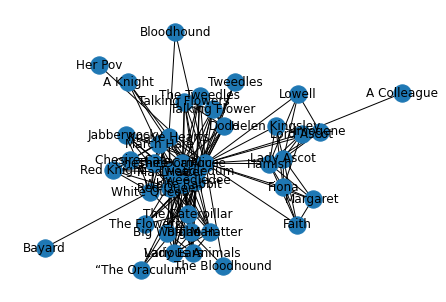

In [261]:
nx.draw(figure_graph, with_labels=True)

In [259]:
nx.write_gexf(figure_graph, "film-2010.gexf")